## Week04 Homework NeuralNetwork

### Visualizing Data

In [1]:
clc;
clear;
close all;

In [2]:
load('ex3data1.mat');
whos

Variables in the current scope:

   Attr Name        Size                     Bytes  Class
   ==== ====        ====                     =====  ===== 
        X        5000x400                 16000000  double
        y        5000x1                      40000  double

Total is 2005000 elements using 16040000 bytes



`gray` 默认会返回一个 64 * 3 的 colormap。 默认是 64 行，自己可以设置。一行三个元素的分别代表 RGB 值。 然后可以用 `colormap` 来设置当前的 colormap.

m =  5000
n =  400
sel =

   4864   3806   4688   3529



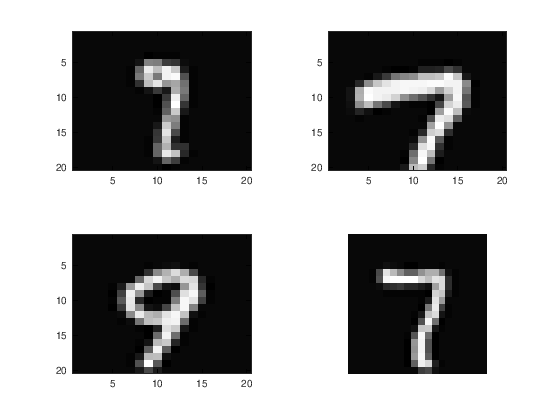

In [3]:
% 将第一个测试数据显示出来。imagesc: Display a scaled version of the matrix IMG as a color image.
[m n] = size(X)
rand_indices = randperm(m); % randperm 返回 1 ~ M 的随机排列。然后我们从中选择几个就都是随机生成了，而且不会有重复的随机数。
sel = rand_indices(1:4)
subplot(2, 2, 1)
colormap(gray)
imagesc(reshape(X(sel(1),:), 20, 20))

subplot(2, 2, 2)
colormap(gray)
imagesc(reshape(X(sel(2),:), 20, 20))

subplot(2, 2, 3)
colormap(gray)
imagesc(reshape(X(sel(3),:), 20, 20))

subplot(2, 2, 4)
colormap(gray)
imagesc(reshape(X(sel(4),:), 20, 20))
axis image off

In [4]:
% display function
function displayData(sel, root)
    colormap(gray);
    width = 20;
    height = 20;
    pad = 1;
    rows = root;
    cols = root;
    display_arrays = -ones(pad + rows * (height + 1), pad + cols * (width + 1));
    for i = 1:root
        for j = 1:root
            index = (i - 1) * root + j;
            % Octave 中的数组访问可以是 scalar, 当然也可以传一个数组，会把数组中的值当成下标来取值。
            display_arrays(
                pad + (j - 1) * (height + pad) + (1:height),
                pad + (i - 1) * (width + pad) + (1:width)
            ) = reshape(sel(index, :), 20, 20) / max(abs(sel(index, :)));
        end
    end
    imagesc(display_arrays, [-1, 1]);
end

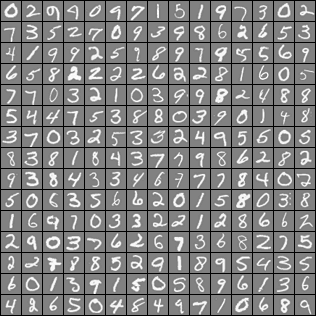

In [5]:
% 我们可以随机将 15 * 15 个数字显示在一起，看一下数据。
[m, n] = size(X);
randIndices = randperm(m); % 随机选择一个 permutaion.
displayData(X(randIndices(1:225), :), 15)

现我们需要识别0-9的数字，于是我们需要训练一个 multiclass classifier. 这个分类器还是得用 Logistic Regression 来学习出来，由于我们有 10 个类别，所以我们需要调用十次 Logistic classifier. 为了方便使用下标，我们将 0 类标记成 10.

In [6]:
% sigmoid function 
function x = sigmoid(z) 
    x = 1 ./ (1 + exp(-z));
end

% compute cost function with regularization.
function [J, grad] = computeCostFunction(theta, X, y, lambda)
    m= length(y);
    h = sigmoid(X * theta);
    J = -(1/m) * sum(y .* log(h) + (1 - y) .* log(1 - h)) + (lambda / (2 * m)) * sum(theta(2:end) .^ 2);
    grad = (1/m) * X' * (h - y) + (lambda / m) * theta;
    grad(1) -= (lambda / m) * theta(1);
end

In [7]:
fprintf('\nTesting lrCostFunction() with regularization');

theta_t = [-2; -1; 1; 2];
X_t = [ones(5,1) reshape(1:15,5,3)/10];
y_t = ([1;0;1;0;1] >= 0.5);
lambda_t = 3;
[J grad] = computeCostFunction(theta_t, X_t, y_t, lambda_t);

fprintf('\nCost: %f\n', J);
fprintf('Expected cost: 2.534819\n');
fprintf('Gradients:\n');
fprintf(' %f \n', grad);
fprintf('Expected gradients:\n');
fprintf(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n');


Testing lrCostFunction() with regularization

Cost: 2.534819
Expected cost: 2.534819
Gradients:
 0.146561 
 -0.548558 
 0.724722 
 1.398003 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


In [8]:
[m, n] = size(X);
XMat = [ones(m, 1), X];
theta = zeros(n + 1, 1); % 测试的时候初始化 theta 全为 0， 计算更快。
[J, grad] = computeCostFunction(theta, XMat, y == 1, 0.1);
J

J =  0.69315


下面我们来构建我们的 multiclass classifier.

In [9]:
function [all_theta] = multiclassify(X, y, numOfClasses, lambda)
    [m n] = size(X);
    X = [ones(m, 1) X];
    all_theta = zeros(numOfClasses, n + 1);
    options = optimset('GradObj', 'on', 'MaxIter', 50);
    
    for i = 1:numOfClasses
        all_theta(i, :) = fmincg(@(t)(computeCostFunction(t, X, y == i, lambda)), all_theta(i, :)', options);
    end
end

In [10]:
% 使用 fmincg 函数计算更快一些并且输出 cost.
[all_theta] = multiclassify(X, y, 10, 0.1);

Iteration    50 | Cost: 1.398863e-02
Iteration    50 | Cost: 5.725261e-02
Iteration    50 | Cost: 6.337243e-02
Iteration    50 | Cost: 3.642163e-02
Iteration    50 | Cost: 6.186929e-02
Iteration    50 | Cost: 2.171516e-02
Iteration    50 | Cost: 3.513457e-02
Iteration    50 | Cost: 8.419062e-02
Iteration    50 | Cost: 8.051420e-02
Iteration    50 | Cost: 9.918967e-03



In [11]:
% 我们在原始数据上测试下我们模型准确率。
function pred = predict(X, all_theta)
    [m n] = size(X);
    X = [ones(m, 1) X];
    [pm, pred] = max(sigmoid(X * all_theta'), [], 2);
end

In [12]:
pre = predict(X, all_theta);

fprintf('The training accuracy is: %f', mean(double(pre == y)) * 100);

The training accuracy is: 95.040000
